## Importing packages & setting up connection

In [138]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [139]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "frostbyte_tasty_bytes",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [140]:
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")
location_df = location_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.location")

In [141]:
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|82686170    |239         |6185.0         |NULL           |NULL           |232187      |15:30:00            |22:30:00          |NULL             |2021-04-

In [142]:
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [143]:
location_df.show()

----------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"PLACEKEY"           |"LOCATION"                       |"CITY"     |"REGION"   |"ISO_COUNTRY_CODE"  |"COUNTRY"  |
----------------------------------------------------------------------------------------------------------------------------------
|9927           |zzy-224@ayt-gj6-v4v  |Ulf Wardau Ballongflyg & Reklam  |Stockholm  |Stockholm  |SE                  |Sweden     |
|12908          |zzy-22h@ayt-gjz-9s5  |Ehrenroth Kristina               |Stockholm  |Stockholm  |SE                  |Sweden     |
|14566          |zzy-25d@ayt-gkd-7t9  |Jo Jo Production                 |Stockholm  |Stockholm  |SE                  |Sweden     |
|6537           |zzy-222@ayt-gjz-68v  |Tanto strandbad                  |Stockholm  |Stockholm  |SE                  |Sweden     |
|14519          |zzy-24b@ayt-gkp-kxq  |Event Opera Stockholm            |Stockholm 

### Dropping of null values in customer id

In [144]:
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|82686626    |227         |6192.0         |88465          |NULL           |232188      |08:00:00            |14:00:00          |NULL             |2021-04-

## 2. Data Exploration <a id="part2"></a>

## 3. Data Preparation <a id="part3"></a>

### 3.1 Create dataframe <a id="part3-1"></a>
As mentioned earlier, our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [145]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [146]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only


customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

### 3.2 Null Value Treatment for us_customer_df <a id="part3-2"></a>
After creating of the relevant data frames that we need, we will need to do null value treatment to further prepare our dataset for modelling. However, based on the data exploration done previously, we realised that the columns that contains null value will not be affecting the clustering of the model. Hence, we will drop the columns. 

In [147]:
# Drop irrelevant columns that will not be affecting the clustering of model and/or are all null
us_customer_df = us_customer_df.drop(["FIRST_NAME", "LAST_NAME", "FAVOURITE_BRAND", "E_MAIL", "PHONE_NUMBER", "POSTAL_CODE"])

# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]
print(cat_cols)

['CITY', 'COUNTRY', 'PREFERRED_LANGUAGE', 'GENDER', 'MARITAL_STATUS', 'CHILDREN_COUNT']


In [148]:
# Missing value percentage
for i in cat_cols:
    print(i + ":", (us_customer_df.count() - us_customer_df.na.drop(subset = i).count())/us_customer_df.count())

CITY: 0.0
COUNTRY: 0.0
PREFERRED_LANGUAGE: 0.0
GENDER: 0.0
MARITAL_STATUS: 0.0
CHILDREN_COUNT: 0.0


### 3.3 Replacing values <a id="part3-3"></a>

In [149]:
# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'COUNTRY': '[\n  "United States"\n]',
 'PREFERRED_LANGUAGE': '[\n  "English"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]',
 'CHILDREN_COUNT': '[\n  "0",\n  "1",\n  "Undisclosed",\n  "2",\n  "4",\n  "5+",\n  "3"\n]'}

Based on the above code, we can drop "COUNTRY" and "PREFERRED_LANGAUGE" as they contain the same value. 

In [150]:
# Drop "COUNTRY" and "PREFERRED_LANGAUGE"
us_customer_df = us_customer_df.drop(["COUNTRY", "PREFERRED_LANGUAGE"])

#### Replace 'Undisclosed' in CHILDREN_COUNT
Since most of the other values in CHILDREN_COUNT is an integer, let's replace the values 'Undisclosed' and '5+'. This would help in the encoding portion.

In [151]:
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT") == "Undisclosed", "0", F.col("CHILDREN_COUNT")))

We are replacing the "Undisclosed" values in the children count column with '0' because we don't have information about the number of children for those customers. Since the children count column represents the count of children a customer has, it doesn't make sense to keep the "Undisclosed" as a value. We are assuming that customers with "Undisclosed" values in the children count column have no children. We are not replacing or dropping them because it wouldn't make sense to encode those values, and dropping the rows would result in significant data loss.

In [152]:
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.iff(F.col("CHILDREN_COUNT")== "5+", "5", F.col("CHILDREN_COUNT")))

By replacing the "5+" values with '5', we are making a reasonable assumption to simplify the data and create a more consistent representation of the children count. This simplification allows for easier analysis and modeling while still capturing the general information about customers with a larger number of children.

Now that all the values in "CHILDREN_COUNT" is an integer, we will convert the column to integer.

In [153]:
# Convert "CHILDREN_COUNT" to integer
us_customer_df = us_customer_df.withColumn("CHILDREN_COUNT", F.col("CHILDREN_COUNT").cast("int"))

### 3.4 Categorical encoding for us_customer_df <a id="part3-4"></a>
Categorical encoding is needed as machine learning models are not able to handle categorical variables. 

In [154]:
# Update categorical columns list
cat_cols = [c.name for c in us_customer_df.schema.fields if type(c.datatype) == T.StringType]

# Distinct values in each column
dist_vals = us_customer_df.select([F.array_agg(col, is_distinct=True).as_(col) for col in cat_cols]).collect()[0].as_dict()
dist_vals

{'CITY': '[\n  "San Mateo",\n  "New York City",\n  "Boston",\n  "Denver",\n  "Seattle"\n]',
 'GENDER': '[\n  "Male",\n  "Undisclosed",\n  "Female"\n]',
 'MARITAL_STATUS': '[\n  "Single",\n  "Married",\n  "Undisclosed",\n  "Divorced/Seperated"\n]'}

We will use categorical encoding to ensure that all the data are in numerical format. “CITY”, “GENDER” and “MARITAL_STATUS” in the customer dataset will be encoded.

In [155]:
# city [Frequency Encoding]
us_customer_df.group_by("CITY").agg(F.count("CUSTOMER_ID").alias("CID"))
freq_enc = us_customer_df.groupBy("CITY").agg(F.count("CUSTOMER_ID").alias("city_frequency"))
    # join the encoded column back to the original DataFrame
us_customer_df = us_customer_df.join(freq_enc, us_customer_df.CITY == freq_enc.CITY, lsuffix = "", rsuffix = "_FREQ_ENC")

Using frequency encoding for "CITY" can help to retain valuable information such as the distribution of each city in the dataset.

Label encoding will be applied to “GENDER” and “MARITAL_STATUS”. 

In [156]:
# Gender [Label Encoding]
#  Male -> 0
#  Female -> 1
#  Undisclosed -> 2

us_customer_df = us_customer_df.withColumn("Gender", F.when(us_customer_df["GENDER"] == "Male", "0")
                                             .when(us_customer_df["GENDER"] == "Female", "1").otherwise("2"))

In [157]:
# Marital status [Label Encoding]
#  Married -> 0 
#  Single -> 1
#  Divorced/seperated -> 2 
#  Undisclosed -> 3

us_customer_df = us_customer_df.withColumn(
    "MARITAL_STATUS",
    F.when(us_customer_df["MARITAL_STATUS"] == "Married", "0")
    .when(us_customer_df["MARITAL_STATUS"] == "Single", "1")
    .when(us_customer_df["MARITAL_STATUS"] == "Divorced/Seperated", "2")
    .otherwise("3")
)

### 3.5 Calculating customer's age <a id="part3-5"></a>
“BIRTHDAY_DATE” will be replaced by “AGE” instead, with the last order transaction date recorded based on all the customers as the current date. 

In [158]:
# Calculating of the age of each customer based on the last order transaction date recorded based on all customers as current date 
last_date = order_header_df.agg(F.max("ORDER_TS")).collect()[0][0]
us_customer_df = us_customer_df.withColumn("Last_date", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), last_date, last_date))
us_customer_df = us_customer_df.withColumn("AGE", F.datediff("year", F.col("BIRTHDAY_DATE"), F.col("Last_date")))

In [159]:
# Dropping of categorical columns and unnecessary columns 
us_customer_df = us_customer_df.drop("CITY", "CITY_FREQ_ENC", "LAST_DATE", "BIRTHDAY_DATE")

# Final customer dataframe
us_customer_df.show(10)

--------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
--------------------------------------------------------------------------------------------------------------
|118            |2019-07-07      |0                 |10613             |0         |1                 |34     |
|189            |2020-03-06      |1                 |10613             |2         |0                 |38     |
|204            |2021-10-10      |0                 |10613             |0         |3                 |43     |
|42             |2020-07-11      |0                 |10613             |2         |1                 |56     |
|59             |2020-12-29      |2                 |10613             |0         |0                 |61     |
|65             |2020-11-05      |5                 |10613             |0         |2                 |64     |
|

### 3.6 Calculating RFM <a id="part3-6"></a>

#### 3.6.1 Calculation of Recency <a id="part3-6-1"></a>
To calculate the recency of orders for each customer, we will take the last order timestamp of the customer minus the current date identified. 

In [160]:
# Finding the last order time stamp for each customer
customer_last_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))

In [161]:
# Finding the first and latest transaction timestamps

# First transaction timestamp
order_header_df.agg(F.min("ORDER_TS")).show()

# Lastest transaction timestamp
order_header_df.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [162]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency = customer_last_order_timestamp.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), "2022-11-01", "0"))

# Calculate recency days
customer_recency = customer_recency.with_column("RECENCY_DAYS", F.datediff('day', customer_recency["LAST_ORDER_TS"], customer_recency["CURRENT DATE"]))
customer_recency.show()

-------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------
|70625          |2022-10-22 18:57:16  |2022-11-01      |10              |
|61591          |2022-10-26 17:54:46  |2022-11-01      |6               |
|171000         |2022-10-30 09:56:03  |2022-11-01      |2               |
|159549         |2022-11-01 16:53:23  |2022-11-01      |0               |
|115424         |2022-10-28 19:43:52  |2022-11-01      |4               |
|191590         |2022-11-01 13:19:30  |2022-11-01      |0               |
|61495          |2022-10-29 10:49:17  |2022-11-01      |3               |
|31451          |2022-10-18 22:27:14  |2022-11-01      |14              |
|170430         |2022-10-17 19:11:47  |2022-11-01      |15              |
|181391         |2022-10-30 12:31:21  |2022-11-01      |2               |
--------------------------------------

In [163]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_final = temp_customer_recency.join(customer_df, 
                                customer_df.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

#### 3.6.2 Calculation of Frequency <a id="part3-6-2"></a>
To calculate the frequency of orders for each customer, we will be calculating the total order by customers divided by the duration between their first order and the current date identified.

In [164]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|79393          |2019-07-07 19:18:31  |
|97467          |2019-09-22 18:28:32  |
|100201         |2019-05-03 08:57:29  |
|116361         |2019-05-29 21:27:35  |
|62668          |2019-10-26 18:16:11  |
---------------------------------------



In [165]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_header_df.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|96975          |57             |
|94580          |71             |
|144225         |62             |
|151133         |63             |
|127470         |51             |
---------------------------------



In [166]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-11-01", "0"))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

In [167]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_final = temp_customer_freq.join(customer_final, 
                                customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

#### 3.6.3 Calculation of Monetary Value <a id="part3-6-3"></a>
To calculate the monetary value for each customer, we will be calculating the total sales generated by each customer divided by the number of years the customer has ordered with Tasty Bytes. 

In [168]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_header_df.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [169]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_final = temp_customer_freq.join(customer_final, customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

In [170]:
customer_final = customer_final.select(
    ["CUSTOMER_ID", "TOTAL_SPENT", 
     "YEARS_WITH_US", "TOTAL_ORDER", 
     "RECENCY_DAYS", "CUSTOMER_FREQUENCY", "MONETARY_VALUE"])

# Merge with customer details
customer_final = customer_final.join(us_customer_df, customer_final.CUSTOMER_ID == us_customer_df.CUSTOMER_ID, lsuffix = "", rsuffix = "_enc")

# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_final = customer_final.drop(["CUSTOMER_ID_ENC", "SIGN_UP_DATE"])
customer_final.show(10)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|169614         |3014.7500      |2.794521         |74             |10              |24.289571             |1078.8074235263   |1                 |7288              |0         |0                 |71     |
|107415         |2698.0000      |2.800000         |64             |15              |20.969478             |963.5714285714    |4                 |7288              |0         |2            

### 3.7 Calculating Customer Purchase Patterns<a id="part3-7"></a>

#### 3.7.1 Calculation of Average Days between Purchases <a id="part3-7-1"></a>

In [171]:
# Finding the average days between purchase for each customer
customer_order_times = order_header_df.sort(col("CUSTOMER_ID"), col("ORDER_TS"))
customer_order_times = customer_order_times.withColumn("prev_order_date", F.lag(col("ORDER_TS"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS"))).withColumn("days_between", F.datediff('day', col("prev_order_date"), col("ORDER_TS")))
customer_average_days = customer_order_times.groupBy("CUSTOMER_ID").avg("days_between")
customer_average_days = customer_average_days.sort(col('CUSTOMER_ID'))
customer_average_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |
---------------------------------------
|22             |29.139535            |
|42             |32.564103            |
|59             |33.157895            |
|65             |29.095238            |
|106            |23.604167            |
|118            |29.205128            |
|166            |20.325581            |
|176            |30.212121            |
|189            |26.102041            |
|204            |27.388889            |
---------------------------------------



In [172]:
customer_final = customer_average_days.join(customer_final, 
                                customer_final.CUSTOMER_ID==customer_average_days.CUSTOMER_ID, lsuffix="", rsuffix="_AVG_DAYS_WITHOUT_PURCHASE")
customer_final.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |29.205128            |118                                      |1419.2500      |2.876712         |40             |3               |12.784589             |493.3583897171    |0        

#### 3.7.2 Calculation the Minimum Number of Days without Customer Purchase <a id="part3-7-2"></a>

In [173]:
# Finding the minimum days without purchase for each customer
customer_min_days = customer_order_times.groupBy("CUSTOMER_ID").min("days_between")
customer_min_days = customer_min_days.sort(col('CUSTOMER_ID'))
customer_min_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |
---------------------------------------
|22             |1                    |
|42             |1                    |
|59             |1                    |
|65             |2                    |
|106            |1                    |
|118            |1                    |
|166            |1                    |
|176            |1                    |
|189            |1                    |
|204            |1                    |
---------------------------------------



In [174]:
customer_final = customer_min_days.join(customer_final, 
                                customer_final.CUSTOMER_ID==customer_min_days.CUSTOMER_ID, lsuffix="", rsuffix="_MIN_DAYS_WITHOUT_PURCHASE")
customer_final.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118   

#### 3.7.3 Calculation the Maximum Number of Days without Customer Purchase <a id="part3-7-3"></a>

In [175]:
# Finding the maximum days without purchase for each customer
customer_max_days = customer_order_times.groupBy("CUSTOMER_ID").max("days_between")
customer_max_days = customer_max_days.sort(col('CUSTOMER_ID'))
customer_max_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |
---------------------------------------
|22             |173                  |
|42             |167                  |
|59             |390                  |
|65             |207                  |
|106            |158                  |
|118            |158                  |
|166            |119                  |
|176            |139                  |
|189            |164                  |
|204            |172                  |
---------------------------------------



In [176]:
customer_final = customer_max_days.join(customer_final, 
                                customer_final.CUSTOMER_ID==customer_max_days.CUSTOMER_ID, lsuffix="", rsuffix="_MAX_DAYS_WITHOUT_PURCHASE")
customer_final.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [177]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_final = customer_final.drop(["CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"])
customer_final.show(10)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |158                  |1                    |29.205128            |1419.2500      |2.876712         |40             |3               |12.784589             |493.3583897171    |0

## DATA EXPLORATION

In [178]:
customer_by_recency = customer_final.group_by("RECENCY_DAYS").agg(F.count("CUSTOMER_ID").alias("NO_OF_CUST")).to_pandas()
customer_by_recency.head()

,RECENCY_DAYS,NO_OF_CUST
0,19,901
1,23,483
2,57,42
3,14,1012
4,10,1727


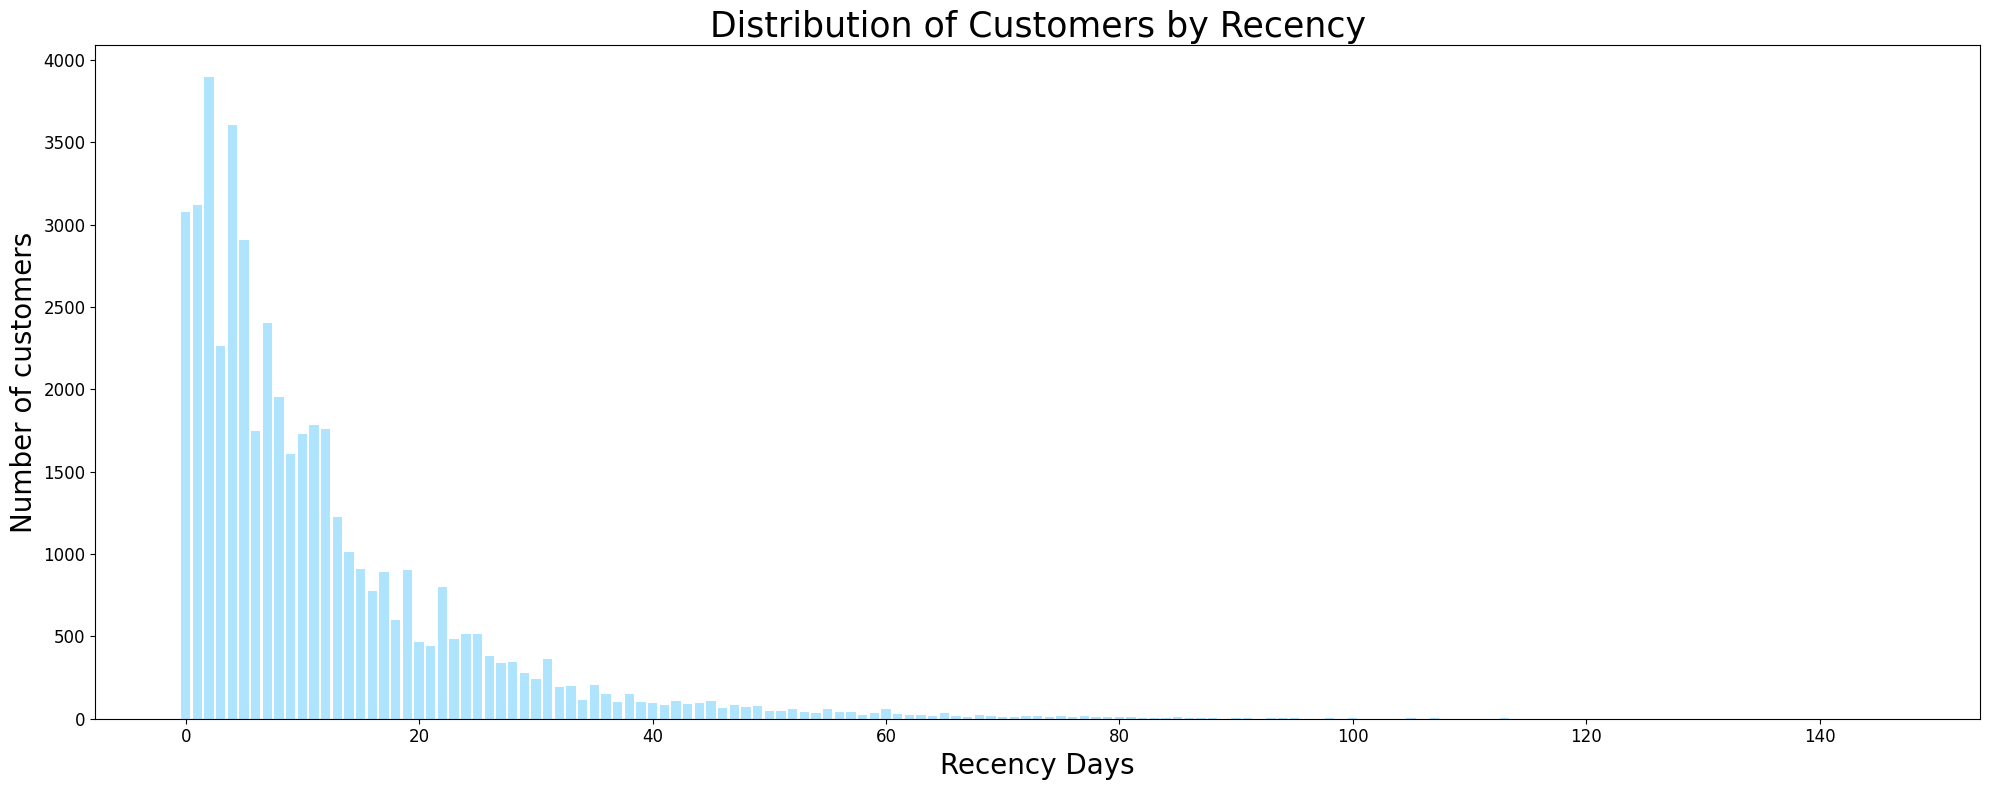

In [179]:
customer_by_recency.sort_values(by='RECENCY_DAYS', ascending=True, inplace=True) # Sort values in ascending order of customer
recency_index = customer_by_recency['RECENCY_DAYS'].tolist()
customer_values = customer_by_recency['NO_OF_CUST'].tolist()

# Create a figure and subplot
fig, V4 = plt.subplots(figsize=(20,8))

# Create a bar chart 
V4.bar(recency_index,customer_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
#for x,y in zip(recency_index,customer_values):

#    label = x

#    plt.annotate(label, 
#                 (x,y), 
#                 textcoords="offset points", 
#                 xytext=(30,-3), 
#                 fontsize = 10,
#                 ha='center') 

# State title of plot and the axes labels
V4.set_title('Distribution of Customers by Recency', fontsize = 25)
V4.set_ylabel('Number of customers', fontsize = 20)
V4.set_xlabel('Recency Days', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
V4.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

In [180]:
# Sum of customers where RECENCY_DAYS is below or equal to 30
sum_below_30 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 30]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 30
sum_above_30 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 30]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 30:", sum_below_30)
print("Sum of customers where RECENCY_DAYS is more than 30:", sum_above_30)
print("prob not this cos data of rows relatively less")

Sum of customers where RECENCY_DAYS is below or equal to 30: 42940
Sum of customers where RECENCY_DAYS is more than 30: 3360
prob not this cos data of rows relatively less


In [181]:
# Find recency days based on percentage of customer (20%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 80% of the customers are at
target_percentage = 0.8
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 80% of the customers are at:", target_recency_days)


RECENCY_DAYS where 80% of the customers are at: 18


In [182]:
# Sum of customers where RECENCY_DAYS is below or equal to 18
sum_below_18 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 18]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 18
sum_above_18 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 18]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 18:", sum_below_18)
print("Sum of customers where RECENCY_DAYS is more than 18:", sum_above_18)

Sum of customers where RECENCY_DAYS is below or equal to 18: 37239
Sum of customers where RECENCY_DAYS is more than 18: 9061


In [183]:
# Find recency days based on percentage of customer (30%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 80% of the customers are at
target_percentage = 0.7
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 70% of the customers are at:", target_recency_days)


RECENCY_DAYS where 70% of the customers are at: 13


In [184]:
# Sum of customers where RECENCY_DAYS is below or equal to 13
sum_below_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 13]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 13
sum_above_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 13]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 13:", sum_below_13)
print("Sum of customers where RECENCY_DAYS is more than 13:", sum_above_13)

Sum of customers where RECENCY_DAYS is below or equal to 13: 33053
Sum of customers where RECENCY_DAYS is more than 13: 13247


### 3.8 Adding Target Variable (Churn or no churn) <a id="part3-8"></a>

As of now:
- 1 -> churn -> recency_days>14
- 0 -> wont churn -> recency_days=<14

In [185]:
customer_final = customer_final.with_column("Target", F.iff(F.col("RECENCY_DAYS") > 14, "1", "0"))
customer_final.show(10)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |"TARGET"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |158                  |1                    |29.205128            |1419.2500      |2.876712         |40             |3               |12.784589 

### 4. Building of models 

#### 4.1 Stratified sampling

In [186]:
customer_final.groupBy(col("TARGET")).count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |34065    |
|1         |12235    |
----------------------



In [187]:
target0 = customer_final.filter(col("TARGET")==0)
target1 = customer_final.filter(col("TARGET")==1)

In [188]:
target0 = target0.sample(n = target1.count())

In [189]:
sampled_customer_final = target0.union(target1)

In [190]:
sampled_customer_final.groupBy(col("TARGET")).count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |12235    |
|0         |12235    |
----------------------



In [191]:
sampled_customer_final.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"CHILDREN_COUNT"  |"CITY_FREQUENCY"  |"GENDER"  |"MARITAL_STATUS"  |"AGE"  |"TARGET"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|204            |172                  |1                    |27.388889            |1263.0000      |2.471233         |37             |8               |13.586517 

#### 4.2 Scaling

In [192]:
sampled_customer_final = sampled_customer_final.to_pandas()

In [193]:
sampled_customer_final = sampled_customer_final.drop(["CUSTOMER_ID", 'CITY_FREQUENCY', 'GENDER', 'MARITAL_STATUS', 'CHILDREN_COUNT', 'RECENCY_DAYS'],  axis = 1)

In [194]:
sampled_customer_final.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,TOTAL_ORDER,CUSTOMER_FREQUENCY,MONETARY_VALUE,AGE,TARGET
0,88,1,17.981132,2267.50,2.361644,54,20.660374,960.1362440740,46,0
1,95,1,15.439394,2032.75,2.547945,67,23.928571,797.7997955215,35,0
2,488,1,40.838710,1442.50,3.221918,32,9.211355,447.7146842347,16,0
3,293,1,35.081081,1237.00,3.304110,38,10.685671,374.3822088248,63,0
4,183,1,29.761905,1718.00,3.183562,43,12.515951,539.6470996952,23,0


In [195]:
#drop target
target = sampled_customer_final['TARGET']
sampled_customer_final.drop('TARGET', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(sampled_customer_final)

final_scaled = scaler.transform(sampled_customer_final)
final_scaled = pd.DataFrame(final_scaled, columns=sampled_customer_final.columns)

#assign target variable back to scaled data frame
final_scaled = final_scaled.assign(TARGET = target)

In [196]:
final_scaled.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,TOTAL_ORDER,CUSTOMER_FREQUENCY,MONETARY_VALUE,AGE,TARGET
0,-0.609750,-0.262225,-0.607239,0.429593,-1.200365,0.077768,0.649255,0.992352,-0.169863,0
1,-0.515141,-0.262225,-0.977885,-0.035015,-0.661613,1.253292,1.402121,0.215468,-0.742467,0
2,4.796441,-0.262225,2.725944,-1.203216,1.287406,-1.911579,-1.988158,-1.459913,-1.731511,0
3,2.160923,-0.262225,1.886344,-1.609934,1.525092,-1.369030,-1.648532,-1.810855,0.715072,0
4,0.674221,-0.262225,1.110680,-0.657957,1.176487,-0.916906,-1.226906,-1.019957,-1.367127,0


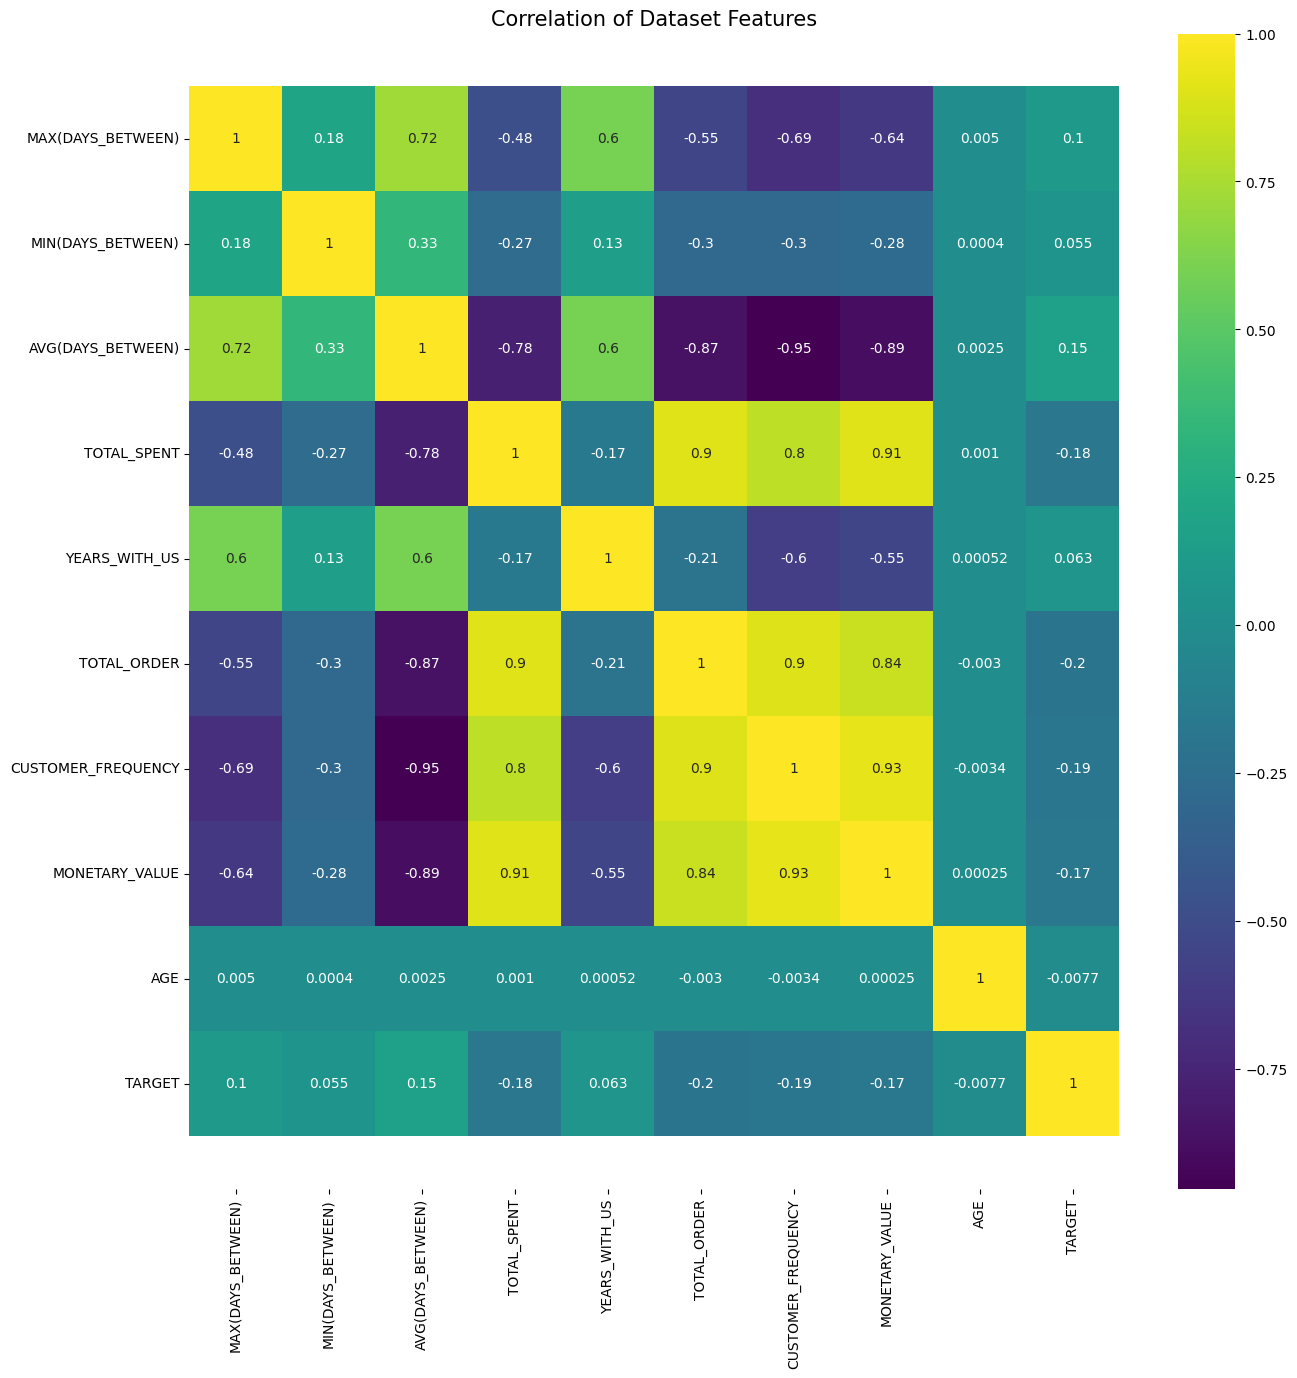

In [197]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Correlation of Dataset Features', size=15)
ax = sns.heatmap(final_scaled.astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### 4.3 Train Test Split

In [198]:
# Define Model Inputs (X) and Output (y)
X = final_scaled.drop('TARGET',axis=1)
y = final_scaled["TARGET"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### 4.4 Logistic Regression Model

In [199]:
# Create the model "lg"
lg = LogisticRegression(solver='lbfgs', 
                        max_iter=10000, random_state = 1) 

# Fit the model to the training set
lg.fit(X_train,y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for Logistic Regression Model is: ', lg.score(X_train, y_train))
print('The testing accuracy for Logistic Regression Model is: ', lg.score(X_test, y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(lg, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for Logistic Regression Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for Logistic Regression Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for Logistic Regression Model is:  0.5996263646447545
The testing accuracy for Logistic Regression Model is:  0.5967851791309086
train_score:  [0.59807928 0.59991827 0.5983347  0.5974152  0.6001226 ]
test_score:  [0.59807928 0.59705762 0.59787495 0.60870454 0.5956273 ]

The Cross Val Train Accuracy for Logistic Regression Model is:  0.5987740089906006
The Cross Val Test Accuracy for Logistic Regression Model is:  0.5994687372292604


#### 4.5 Decision Tree Model

In [200]:
# Create Decision Tree Model
dt = tree.DecisionTreeClassifier(max_depth = 2, random_state = 1)
dt.fit(X_train, y_train)      

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for Decision Tree Model is: ', dt.score(X_train, y_train))
print('The testing accuracy for Decision Tree Model is: ', dt.score(X_test, y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(dt, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for Decision Tree Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for Decision Tree Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for Decision Tree Model is:  0.5817619242220795
The testing accuracy for Decision Tree Model is:  0.5867048086091813
train_score:  [0.58285656 0.58398038 0.58346955 0.58081324 0.58510421]
test_score:  [0.58479771 0.58030241 0.58234573 0.59297098 0.57580711]

The Cross Val Train Accuracy for Decision Tree Model is:  0.5832447895382101
The Cross Val Test Accuracy for Decision Tree Model is:  0.5832447895382101


#### 4.6 Random Forest Model

In [201]:
# Create Random Forest Model
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train,y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for Random Forest Model is: ', rf.score(X_train,y_train))
print('The testing accuracy for Random Forest Model is: ', rf.score(X_test,y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(rf, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for Random Forest Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for Random Forest Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for Random Forest Model is:  1.0
The testing accuracy for Random Forest Model is:  0.850701539299823
train_score:  [1. 1. 1. 1. 1.]
test_score:  [0.86085002 0.85635472 0.85778504 0.86657131 0.86105435]

The Cross Val Train Accuracy for Random Forest Model is:  1.0
The Cross Val Test Accuracy for Random Forest Model is:  0.8605230894973438


#### 4.7 ANN Model

In [202]:
# Create the ann model
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=1)
# Fit the model to the training set
mlp.fit(X_train,y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for ANN Model is: ', mlp.score(X_train, y_train))
print('The testing accuracy for ANN Model is: ', mlp.score(X_test, y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(mlp, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for ANN Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for ANN Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for ANN Model is:  0.5773250043785393
The testing accuracy for ANN Model is:  0.5768968805339872
train_score:  [0.57606253 0.57938292 0.57979158 0.57391704 0.5779526 ]
test_score:  [0.58275439 0.57069881 0.56906416 0.59092767 0.57437679]

The Cross Val Train Accuracy for ANN Model is:  0.5774213322435635
The Cross Val Test Accuracy for ANN Model is:  0.5775643645279934


#### 4.8 SVM Model

In [203]:
# create SVM model 
svm = SVC(random_state = 1)
svm.fit(X_train,y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for SVM Model is: ', svm.score(X_train,y_train))
print('The testing accuracy for SVM Model is: ', svm.score(X_test,y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(svm, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for SVM Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for SVM Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for SVM Model is:  0.7923404752174674
The testing accuracy for SVM Model is:  0.7776869636289334
train_score:  [0.80772374 0.81048222 0.80419902 0.80685533 0.80108296]
test_score:  [0.80322844 0.79995913 0.80118512 0.80404577 0.79158153]

The Cross Val Train Accuracy for SVM Model is:  0.8060686554965264
The Cross Val Test Accuracy for SVM Model is:  0.8


#### 4.9 KNN Model 

Minimum error:- 0.41615583707941695 at K = 38


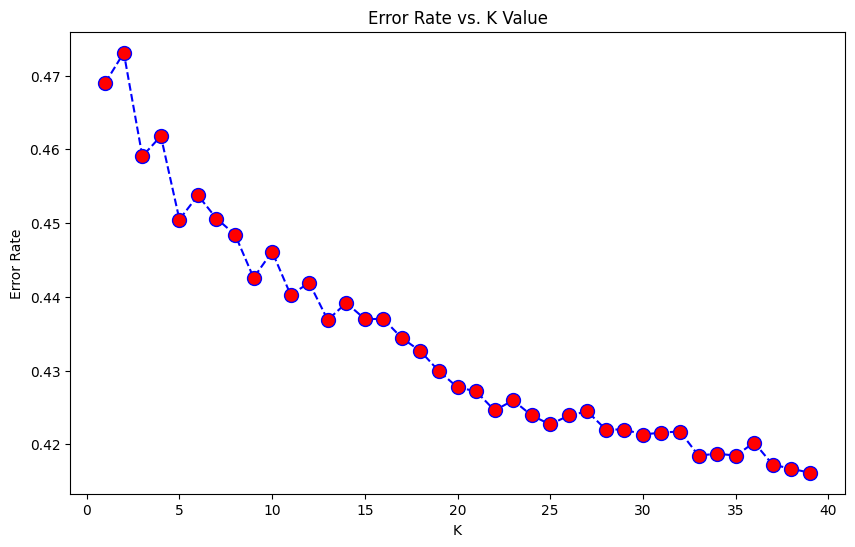

In [204]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.583844162920583 at K = 38


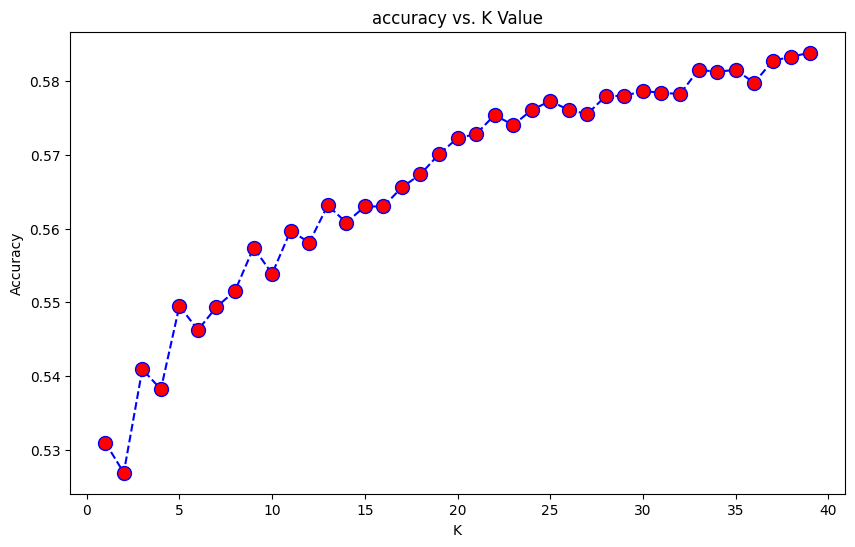

In [205]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [206]:
# Create KNN Model 
knn = KNeighborsClassifier(n_neighbors=34)
knn.fit(X_train, y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for KNN Model is: ', knn.score(X_train,y_train))
print('The testing accuracy for KNN Model is: ', knn.score(X_test,y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(knn, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for KNN Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for KNN Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for KNN Model is:  0.61182789421449
The testing accuracy for KNN Model is:  0.581255959678518
train_score:  [0.61866571 0.61713322 0.61386391 0.61560074 0.61861463]
test_score:  [0.57417246 0.57417246 0.57928075 0.58459338 0.5539436 ]

The Cross Val Train Accuracy for KNN Model is:  0.61677564364528
The Cross Val Test Accuracy for KNN Model is:  0.5732325296281161


#### 4.10 XGBoost Model 

In [207]:
# Convert class labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Create XGBoost model
xgb = XGBClassifier(n_estimators=20, 
                     learning_rate=0.1, 
                     use_label_encoder=False, 
                     eval_metric='logloss',
                     random_state=1)

# Fit the XGBClassifier to the training data
xgb.fit(X_train, y_train)

# Calculate the training and testing accuracy 
# Accuracy Evaluation method
print('The training accuracy for XGBoost Model is: ', xgb.score(X_train, y_train))
print('The testing accuracy for XGBoost Model is: ', xgb.score(X_test, y_test))

# K-folds Cross Validation Evaluation method
results  = cross_validate(xgb, X_train, y_train, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', results['train_score'])
print('test_score: ', results['test_score'])
print("")
print('The Cross Val Train Accuracy for XGBoost Model is: ',sum(results['train_score'])/len(results['train_score']))
print('The Cross Val Test Accuracy for XGBoost Model is: ',sum(results['test_score'])/len(results['test_score']))

The training accuracy for XGBoost Model is:  0.8531729814933738
The testing accuracy for XGBoost Model is:  0.820460427734641
train_score:  [0.84631103 0.84302707 0.87185288 0.84156754 0.86646235]
test_score:  [0.81698774 0.8056042  0.83012259 0.79947461 0.8350365 ]

The Cross Val Train Accuracy for XGBoost Model is:  0.8538441733584359
The Cross Val Test Accuracy for XGBoost Model is:  0.8174451276413514
